In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import PIL.Image as Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers #models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
TRAIN_DIR = "/Users/Mareikes/Desktop/Wahlpflicht_AI/projekt_emotions/emotion_dataset_v2/datasets/train"

In [ ]:
from pathlib import Path

OUT_DIR = Path("../output") # Zielpfad relativ zum Skript)
OUT_DIR.mkdir(parents=True, exist_ok=True)  # Ordner erstellen, falls er noch nicht existiert

### Training

In [4]:
BATCH_SIZES = [16, 32, 64]
img_height = 224
img_width = 224

In [5]:
class_names = sorted(os.listdir(TRAIN_DIR))
num_classes = len(class_names)

In [6]:
# Speichern der Ergebnisse für jede Batchgröße
history_dicts = {}
trained_models = {}

for batch_size in BATCH_SIZES:
    print(f"Training with batch_size={batch_size}")
    
    # Trainings- und Validierungsdaten mit der aktuellen Batch-Größe laden
    train_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        validation_split=0.1,
        subset="training",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        labels='inferred',
        label_mode='int',
        shuffle=True
    )
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        validation_split=0.1,
        subset="validation",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        labels='inferred',
        label_mode='int',
        shuffle=True
    )

    AUTOTUNE = tf.data.AUTOTUNE
    
    # Dataset-Optimierung
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    
    #Augmentation vornehmen > nicht zu viel, da Gesichter erkennbar bleiben sollen
    data_augmentation = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),
    
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    ])
    
    #Modell aufbauen
    base_model = MobileNetV2(
    input_shape= (img_height, img_width, 3),
    include_top=False,
    weights="imagenet")
    base_model.trainable = False  # zunächst einfrieren
    model = tf.keras.Sequential([
        tf.keras.Input(shape= (img_height, img_width, 3)),
        data_augmentation,
        layers.Lambda(preprocess_input),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax") #sollte nicht softmax sein lt buch?
        ])
    
    #kompilieren, optimizer, loss und Metrik festlegen
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['acc'])
    
    # Early Stopping Callback
    early_stopping = EarlyStopping(
        monitor="val_loss", 
        patience=5, 
        restore_best_weights=True 
    )
    #Lernrate Callback
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',    # Überwacht die Validierungs-Fehler
        factor=0.5,            # Halbiert die Lernrate
        patience=5,            # Nach 5 Epochen ohne Verbesserung
        min_lr=1e-6            # Untere Grenze der Lernrate
    )
    
    # Checkpoint Callback definieren zum speichern
    out_path = OUT_DIR / f'transfer_v2_{batch_size}.keras'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        out_path,
        save_best_only=True,
        monitor="val_loss",
        mode="min"
    )
    
    #Modell fitten
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs= 40,
        callbacks=[early_stopping, reduce_lr, checkpoint]
        )
    
    # Speichern des History-Dictionaries
    history_dicts[batch_size] = history.history
    trained_models[batch_size] = model



Training with batch_size=16
Found 3149 files belonging to 2 classes.
Using 2835 files for training.
Found 3149 files belonging to 2 classes.
Using 314 files for validation.
Epoch 1/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - acc: 0.6315 - loss: 0.6765 - val_acc: 0.7739 - val_loss: 0.4610 - learning_rate: 0.0010
Epoch 2/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 1943s 11s/step - acc: 0.7538 - loss: 0.5291 - val_acc: 0.8057 - val_loss: 0.4462 - learning_rate: 0.0010
Epoch 3/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 119s 671ms/step - acc: 0.7740 - loss: 0.4757 - val_acc: 0.8089 - val_loss: 0.4187 - learning_rate: 0.0010
Epoch 4/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 118s 660ms/step - acc: 0.7897 - loss: 0.4597 - val_acc: 0.8248 - val_loss: 0.3838 - learning_rate: 0.0010
Epoch 5/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 118s 662ms/step - acc: 0.7788 - loss: 0.4796 - val_acc: 0.8217 - val_loss: 0.4148 - learning_rate: 0.0010
Epoch 6/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 53s 299ms/step - acc: 0.8215 - loss: 0.4299 - val_acc: 0.8280

### Trainingsverlauf visuell darstellen

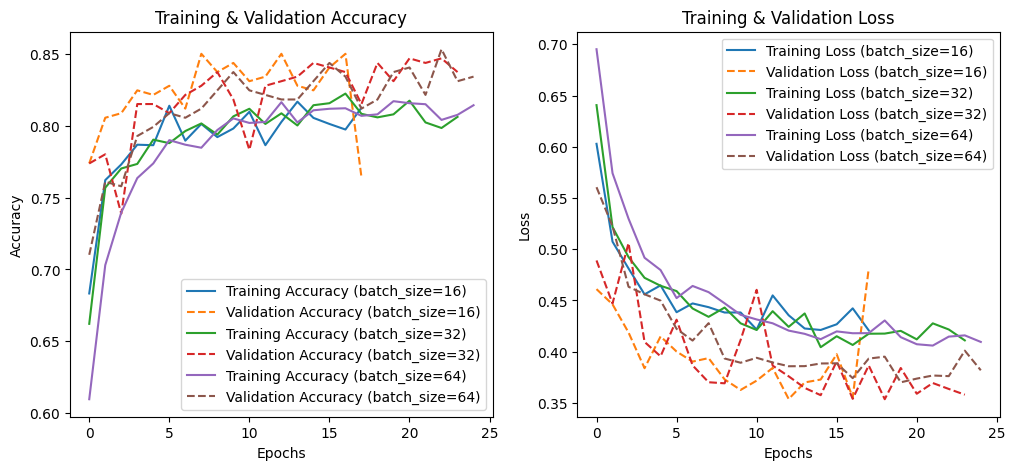

In [7]:

plt.figure(figsize=(12, 5))

# Accuracy (Genauigkeit)
plt.subplot(1, 2, 1)
for batch_size in BATCH_SIZES:
    plt.plot(history_dicts[batch_size]['acc'], label=f'Training Accuracy (batch_size={batch_size})')
    plt.plot(history_dicts[batch_size]['val_acc'], label=f'Validation Accuracy (batch_size={batch_size})', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Training & Validation Accuracy')
plt.legend()

# Loss (Fehlerrate)
plt.subplot(1, 2, 2)
for batch_size in BATCH_SIZES:
    plt.plot(history_dicts[batch_size]['loss'], label=f'Training Loss (batch_size={batch_size})')
    plt.plot(history_dicts[batch_size]['val_loss'], label=f'Validation Loss (batch_size={batch_size})', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()

### Evaluierung

In [8]:
TEST_DIR = "/Users/Mareikes/Desktop/Wahlpflicht_AI/projekt_emotions/emotion_dataset_v2/datasets/test"

In [9]:
#verschiedene Modelle aufrufen
model_16 = trained_models[16]
model_32 = trained_models[32]
model_64 = trained_models[64]

In [10]:
#Confusion Matrix erstellen
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

In [11]:
#Test Datensatz Batch 16
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_DIR,
  seed=42,
  image_size= (224, 224),
  batch_size=16) 

Found 788 files belonging to 2 classes.


In [12]:
class_names = np.array(test_ds.class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-05-20 16:11:53.488157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


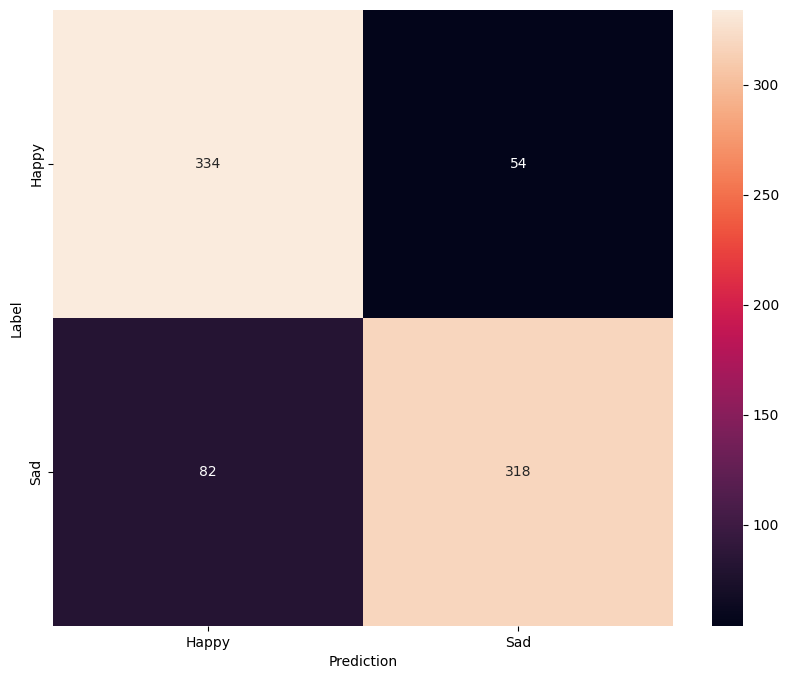

              precision    recall  f1-score   support

       Happy       0.80      0.86      0.83       388
         Sad       0.85      0.80      0.82       400

    accuracy                           0.83       788
   macro avg       0.83      0.83      0.83       788
weighted avg       0.83      0.83      0.83       788



In [13]:
#predictions für Modell mit Batch 16
all_labels = []
all_preds = []

for images, labels in test_ds:
    preds = model_16.predict(images)
    pred_classes = tf.math.argmax(preds, axis=-1)
    all_labels.extend(labels.numpy())
    all_preds.extend(pred_classes.numpy())

cm = confusion_matrix(all_labels, all_preds)
show_confusion_matrix(cm, class_names)
print(classification_report(all_labels, all_preds, target_names=class_names))

In [14]:
#Testdatensatz Batch 32
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_DIR,
  seed=42,
  image_size= (224, 224),
  batch_size=32) 

Found 788 files belonging to 2 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step


2025-05-20 16:12:04.633819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


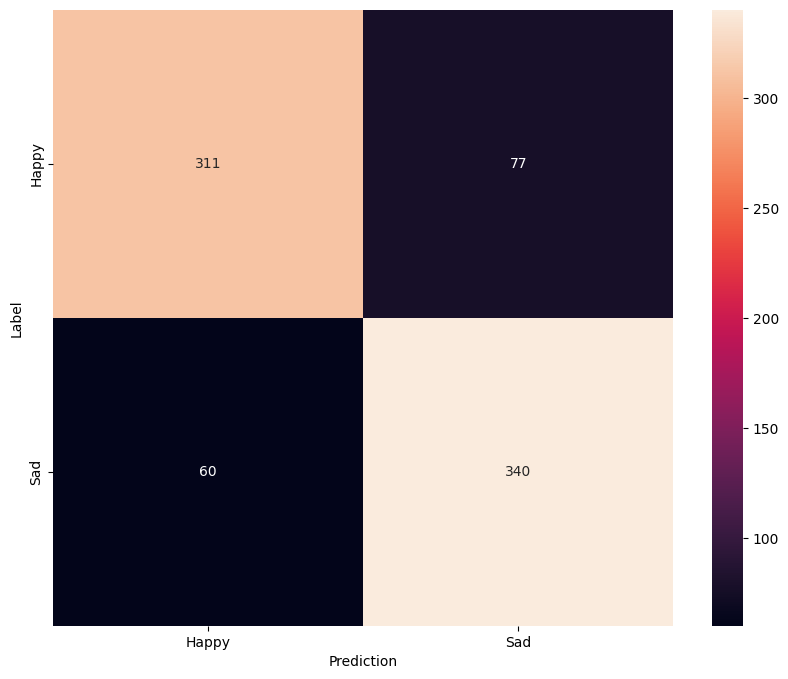

              precision    recall  f1-score   support

       Happy       0.84      0.80      0.82       388
         Sad       0.82      0.85      0.83       400

    accuracy                           0.83       788
   macro avg       0.83      0.83      0.83       788
weighted avg       0.83      0.83      0.83       788



In [15]:
#predictions Modell Batch 32
all_lab = []
all_pred = []

for images, labels in test_ds:
    preds = model_32.predict(images)
    pred_classes = tf.math.argmax(preds, axis=-1)
    all_lab.extend(labels.numpy())
    all_pred.extend(pred_classes.numpy())

cm = confusion_matrix(all_lab, all_pred)
show_confusion_matrix(cm, class_names)
print(classification_report(all_lab, all_pred, target_names=class_names))

In [16]:
#Testdatensatz Batch 64
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_DIR,
  seed=42,
  image_size= (224, 224),
  batch_size=64) 

Found 788 files belonging to 2 classes.


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 928ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 986ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 954ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


2025-05-23 23:56:19.680311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


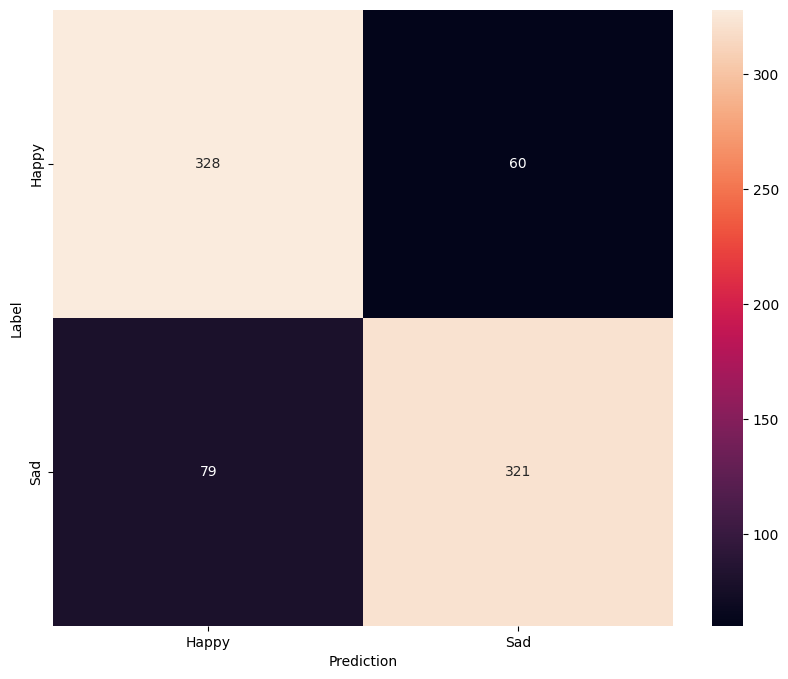

              precision    recall  f1-score   support

       Happy       0.81      0.85      0.83       388
         Sad       0.84      0.80      0.82       400

    accuracy                           0.82       788
   macro avg       0.82      0.82      0.82       788
weighted avg       0.82      0.82      0.82       788



In [19]:
#predictions Modell 64
lab = []
pred = []

for images, labels in test_ds:
    preds = model_64.predict(images)
    pred_classes = tf.math.argmax(preds, axis=-1)
    lab.extend(labels.numpy())
    pred.extend(pred_classes.numpy())

cm = confusion_matrix(lab, pred)
show_confusion_matrix(cm, class_names)
print(classification_report(lab, pred, target_names=class_names))

### Vorhersagen

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


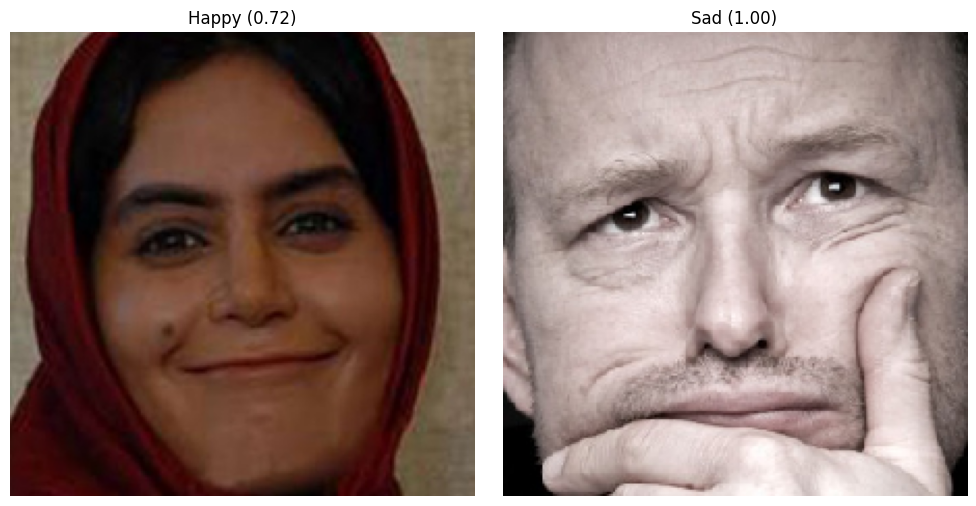

In [22]:
# Klassen definieren (anpassen)
class_names = np.array(['Happy', 'Sad'])


# Bildgröße
img_height, img_width = 224, 224

# Zwei zufällige Bilder auswählen
image_paths = []
for root, _, files in os.walk(TEST_DIR):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

image_paths = np.random.choice(image_paths, 2, replace=False)

# Visualisierung mit Vorhersage
plt.figure(figsize=(10, 5))
for i, path in enumerate(image_paths):
    img = image.load_img(path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)

    # WICHTIG: Kein weiteres preprocess_input mehr nötig – Lambda-Schicht ist im Modell enthalten
    predictions = model_32.predict(img_batch)
    probabilities = predictions[0]

    predicted_class = np.argmax(probabilities)
    confidence = probabilities[predicted_class]

    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{class_names[predicted_class]} ({confidence:.2f})")
plt.tight_layout()
plt.show()
